In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [2]:
df = pd.read_csv('comments_data.csv')
df.shape

(532, 3)

In [3]:
df.head()

,Unnamed: 0,video_id,comments
0,0,z9bJUPxzFOw,['Bhaiya could you tell beforehand if you goin...
1,1,cEadsbTeze4,['easy problem only thing to evaluate that the...
2,2,NwBvene4Imo,"['Good post, slow down the releases and you’ll..."
3,3,eay-zoSRkVc,"[""What a timing. I was solving this problem fr..."
4,4,jmbuRzYPGrg,"['So many edge cases.........Uffffff', '', 'Gr..."


In [4]:
df = df.drop(['Unnamed: 0'], axis=1)

In [5]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

## VADER Model
We will use NLTK's SentimentIntensityAnalyzer to get the neg/neu/pos scores of the text.

This uses a "bag of words" approach:
Stop words are removed
each word is scored and combined to a total score

In [6]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [7]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['comments']
    myid = row['video_id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/532 [00:00<?, ?it/s]

In [10]:
comment_df = pd.DataFrame(res).T

In [15]:
# Assume your DataFrame is named `df`
comment_df.index.name = 'video_id'
comment_df.reset_index(inplace=True)

In [16]:
comment_df

,video_id,neg,neu,pos,compound
0,z9bJUPxzFOw,0.000,0.774,0.226,0.9927
1,cEadsbTeze4,0.049,0.699,0.252,0.9846
2,NwBvene4Imo,0.074,0.926,0.000,-0.4019
3,eay-zoSRkVc,0.112,0.748,0.140,0.4310
4,jmbuRzYPGrg,0.000,0.823,0.177,0.6249
...,...,...,...,...,...
527,GAuI71n71Uc,0.027,0.760,0.213,0.9763
528,Cq_G2kk15U0,0.050,0.713,0.237,0.9810
529,SWABtcS8SU8,0.145,0.773,0.081,-0.9924
530,TocJOW6vx_I,0.087,0.703,0.210,0.9568


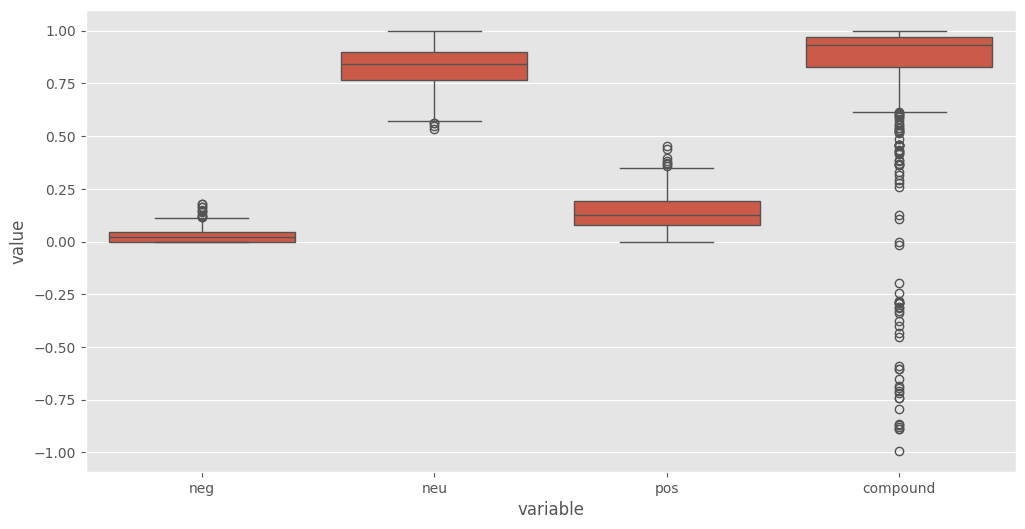

In [17]:
# Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=comment_df[['video_id', 'neg', 'neu', 'pos', 'compound']].melt(id_vars='video_id'), x='variable', y='value')
plt.show()

# Comparing Distributions: Box plots are useful for comparing the distribution of sentiment scores across different categories
# (in this case, across different sentiment scores: negative, neutral, positive, and compound).
# Identifying Outliers: They help identify outliers in your sentiment scores which might indicate unusual or extreme comments.


<Figure size 1200x600 with 0 Axes>

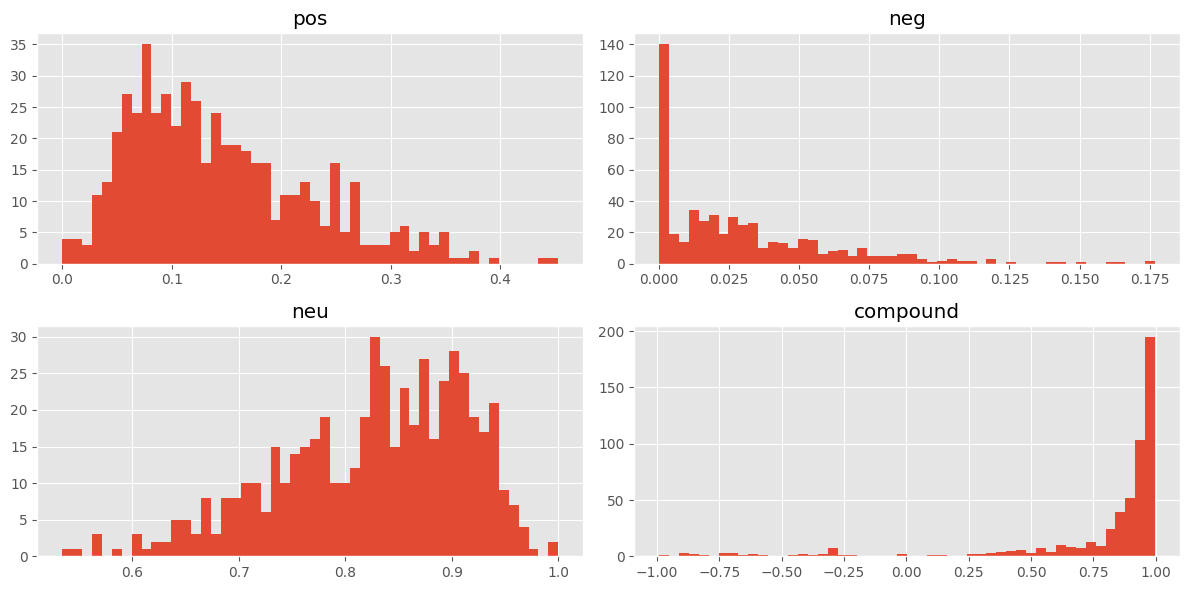

In [18]:
# Histogram
plt.figure(figsize=(12, 6))
comment_df[['pos', 'neg', 'neu', 'compound']].hist(bins=50, figsize=(12, 6))
plt.tight_layout()
plt.show()

# By plotting histograms for the sentiment scores (negative, neutral, positive, and compound), we can understand the overall
# distribution of these scores across all video comments. For example, a histogram of the compound scores can show you whether
# the overall sentiment is more positive, negative, or neutral.
# Identifying Trends: It helps in identifying trends such as if most comments are generally positive, negative, or neutral.


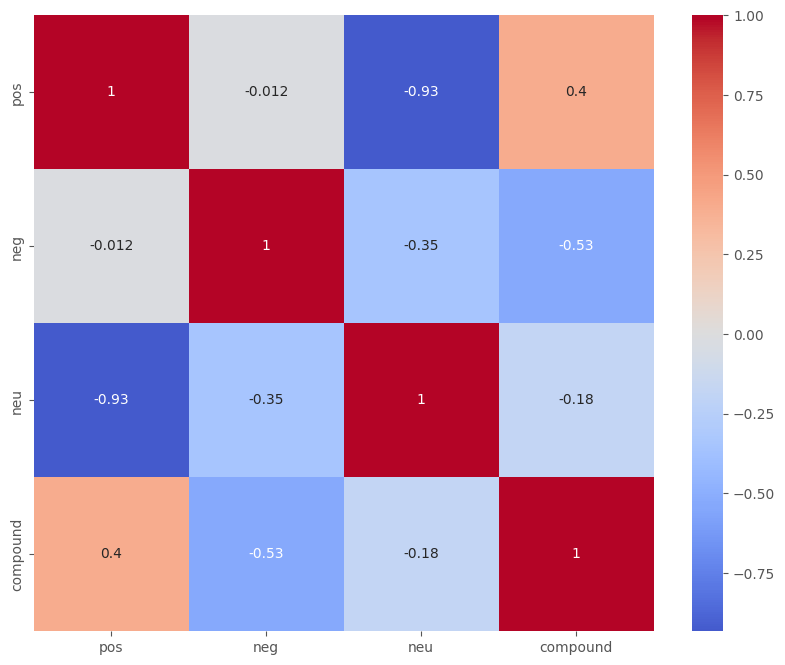

In [22]:
# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(comment_df[['pos', 'neg', 'neu', 'compound']].corr(), annot=True, cmap='coolwarm', center=0)
plt.show()

# Correlation Analysis: In the context of sentiment analysis, a heatmap can show the correlation between different sentiment scores
# (negative, neutral, positive, compound). This can help in understanding how these scores relate to each other. For example, you might
# find that high positive scores are often correlated with high compound scores.
# Visualizing Relationships: It provides a clear, visual way to see relationships between variables which might be less obvious from raw data.


## Roberta Pretrained Model
Use a model trained of a large corpus of data.
Transformer model accounts for the words but also the context related to other words.

In [24]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [25]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [26]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [ ]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['comments']
        myid = row['video_id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

In [30]:
results_df = pd.DataFrame(res).T

In [32]:
# Assume your DataFrame is named `df`
results_df.index.name = 'video_id'
results_df.reset_index(inplace=True)

In [ ]:
results_df

## Comparing both the results

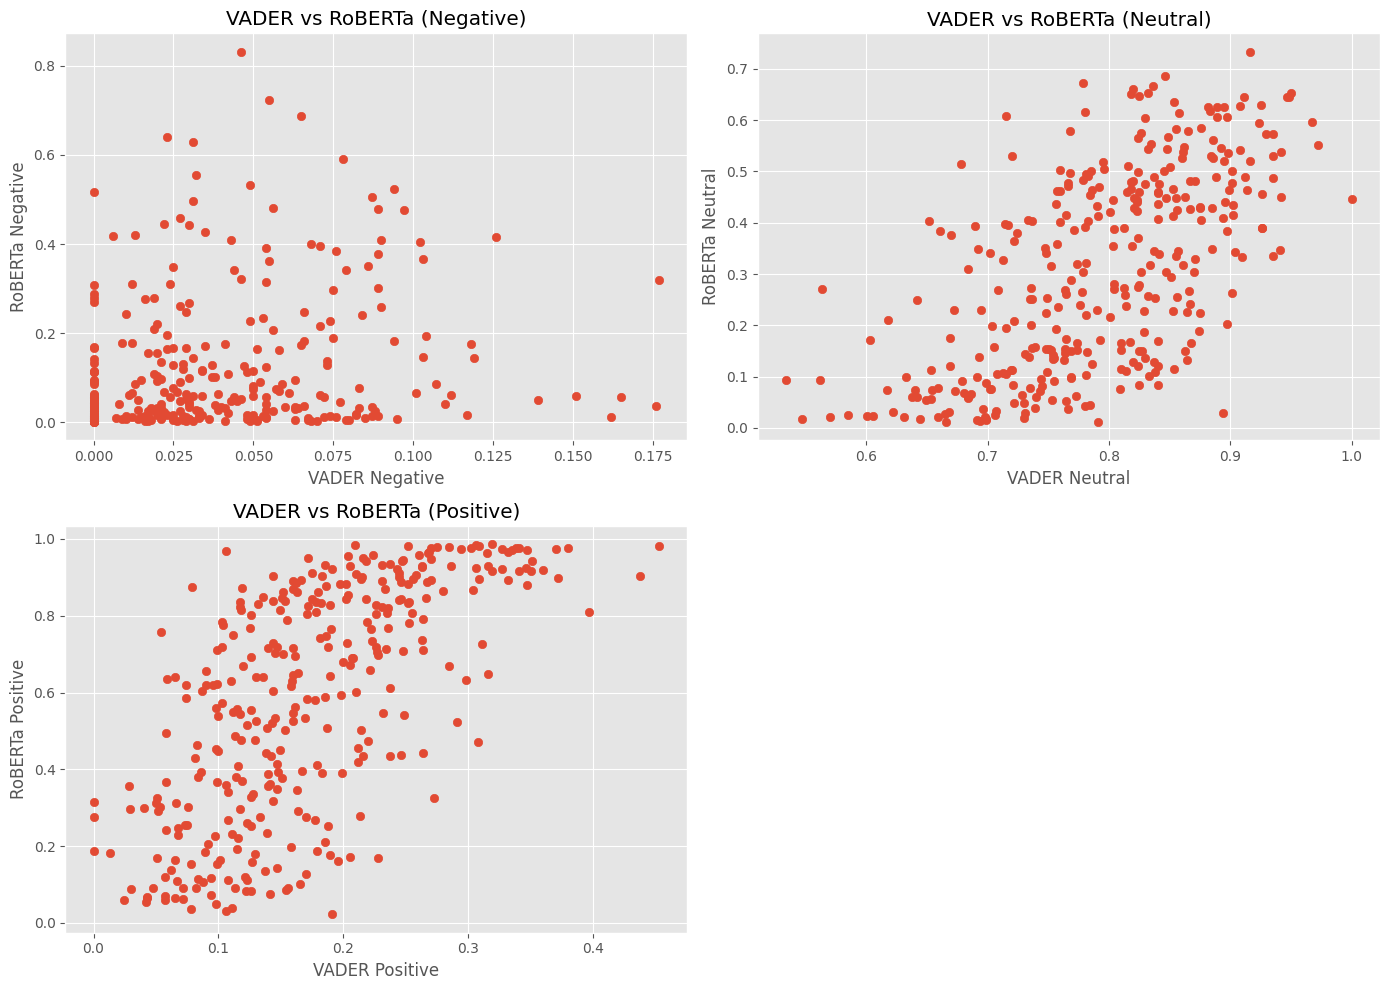

In [35]:
plt.figure(figsize=(14, 10))

# Scatter plot for negative scores
plt.subplot(2, 2, 1)
plt.scatter(results_df['vader_neg'], results_df['roberta_neg'])
plt.title('VADER vs RoBERTa (Negative)')
plt.xlabel('VADER Negative')
plt.ylabel('RoBERTa Negative')

# Scatter plot for neutral scores
plt.subplot(2, 2, 2)
plt.scatter(results_df['vader_neu'], results_df['roberta_neu'])
plt.title('VADER vs RoBERTa (Neutral)')
plt.xlabel('VADER Neutral')
plt.ylabel('RoBERTa Neutral')

# Scatter plot for positive scores
plt.subplot(2, 2, 3)
plt.scatter(results_df['vader_pos'], results_df['roberta_pos'])
plt.title('VADER vs RoBERTa (Positive)')
plt.xlabel('VADER Positive')
plt.ylabel('RoBERTa Positive')

plt.tight_layout()
plt.show()

In [36]:
# Calculate mean sentiment scores for VADER
vader_mean_scores = results_df[['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']].mean()

# Calculate mean sentiment scores for RoBERTa
roberta_mean_scores = results_df[['roberta_neg', 'roberta_neu', 'roberta_pos']].mean()

# Combine both results into a single DataFrame for comparison
mean_scores = pd.DataFrame({'VADER': vader_mean_scores, 'RoBERTa': roberta_mean_scores})
print(mean_scores)


                   VADER   RoBERTa
roberta_neg          NaN  0.110982
roberta_neu          NaN  0.306566
roberta_pos          NaN  0.582453
vader_compound  0.769256       NaN
vader_neg       0.034878       NaN
vader_neu       0.790724       NaN
vader_pos       0.174377       NaN


In [37]:
# Determine overall sentiment for VADER
vader_overall_sentiment = 'Positive' if vader_mean_scores['vader_compound'] > 0 else ('Negative' if vader_mean_scores['vader_compound'] < 0 else 'Neutral')

# Determine overall sentiment for RoBERTa
roberta_overall_sentiment = 'Positive' if roberta_mean_scores['roberta_pos'] > roberta_mean_scores['roberta_neg'] else ('Negative' if roberta_mean_scores['roberta_pos'] < roberta_mean_scores['roberta_neg'] else 'Neutral')

print(f"Overall VADER Sentiment: {vader_overall_sentiment}")
print(f"Overall RoBERTa Sentiment: {roberta_overall_sentiment}")


Overall VADER Sentiment: Positive
Overall RoBERTa Sentiment: Positive


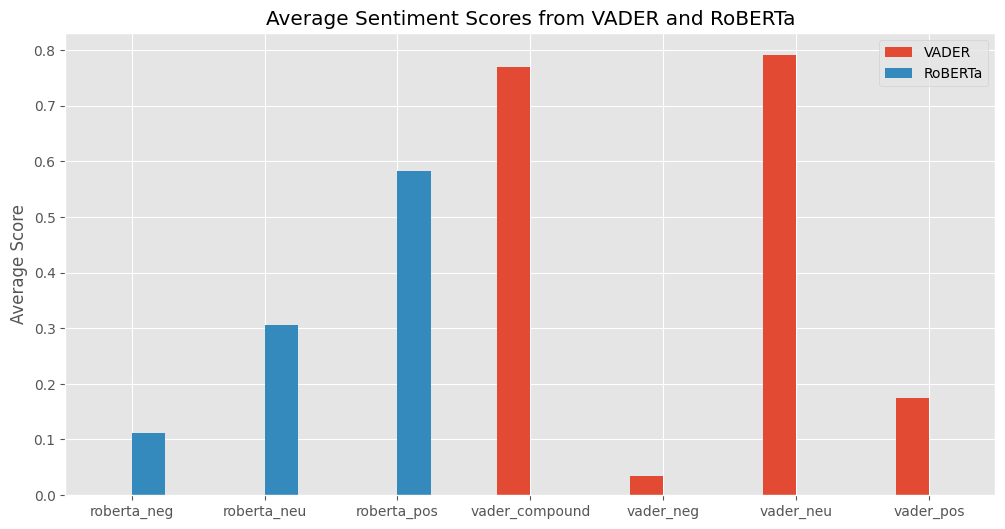

In [38]:
import matplotlib.pyplot as plt

# Plot average sentiment scores for comparison
mean_scores.plot(kind='bar', figsize=(12, 6))
plt.title('Average Sentiment Scores from VADER and RoBERTa')
plt.ylabel('Average Score')
plt.xticks(rotation=0)
plt.show()


## Conclusion :       
From all this above analysis, we can infer that the overall response of audience on this channel is **positive**.